# **CS357000 Introduction to Multimedia - HW3**

In this homework, you'll be engaging with fundamental concepts of motion estimation, including 
+   Implementation and visualization
+   Temporal Performance Analysis of Motion Estimation
+   Computational Efficiency analysis

Each question is designed to build your understanding and skills in these areas.   
Follow the instructions carefully and complete the tasks in the provided code blocks.  
Additionally, you will be required to write a report in the designated sections to explain your methodology and findings.  

# **Submission**
+   Ensure that you have completed all tasks and filled in all reports before submitting.
+   Compress your code and results in a zip file named HW3_{StudentID}.zip and upload to eeclass before the deadline 
+   The structure and naming of the files must be consistent with the specifications outlined in the description file

In [1]:
# Lib
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

In [2]:
def calculate_SAD(ref_block, target_block):
    '''
    In :
        ref_block : reference block
        target_block : target block
    Out : 
        sad : SAD value
    '''
    # TODO calculate the SAD value
    SAD = np.sum(np.abs(ref_block.astype(int) - target_block.astype(int)))
    
    return SAD

In [3]:
def calculate_PSNR(predicted_img, target_img):
    '''
    In :
        predicted_img : predicted image
        target_img : target image
    Out : 
        PSNR : PSNR value
    '''
    # TODO calculate the PSNR value
    MSE = np.mean(np.sum(((predicted_img.astype(int) - target_img.astype(int)) ** 2), axis=-1))
    PSNR = 10 * np.log10((255) ** 2 / MSE)
    
    return PSNR

In [4]:
def full_search(ref_img, target_block, corner_pt, search_range, block_size):
    '''
    In :
        ref_img : reference image
        target_block : target block
        corner_pt : top-left corner coordinate of the target block, (x, y) = (col, row)
        search_range : search range
        block size : size of macroblock
    Out : 
        predicted_block : predicted block
        motion vector : motion vector
        SAD : SAD value
    '''
    # TODO calculate the predicted block, motion vector, and SAD value
    predicted_block = target_block.copy()
    motion_vector = np.zeros(2)
    h, w, c = ref_img.shape
    target_i, target_j = corner_pt[1], corner_pt[0]

    # search boundary
    top = target_i - search_range if target_i - search_range > 0 else 0
    bottom = target_i + search_range if target_i + search_range + block_size <= h else h - block_size
    left = target_j - search_range if target_j - search_range > 0 else 0
    right = target_j + search_range if target_j + search_range + block_size <= w else w - block_size

    # full search
    min_SAD = 1e9
    best_i, best_j = 0, 0
    for i in range(top, bottom):
        for j in range(left, right):
            ref_block = ref_img[i:i+block_size, j:j+block_size, :]
            now_SAD = calculate_SAD(ref_block, target_block)
            if(now_SAD < min_SAD):
                min_SAD = now_SAD
                best_i, best_j = i, j
                predicted_block = ref_block.copy()
                
    
    motion_vector[0] = int(best_j - target_j)
    motion_vector[1] = int(best_i - target_i)
    SAD = min_SAD

    return predicted_block, motion_vector, SAD

In [5]:
def twoD_log_search(ref_img, target_block, corner_pt, search_range, block_size):
    '''
    In :
        ref_img : reference image
        target_block : target block
        corner_pt : top-left corner coordinate of the target block
        search_range : search range
        block size : size of macroblock
    Out : 
        predicted_block : predicted block
        motion vector : motion vector
        SAD : SAD value
    '''
    # TODO calculate the predicted block, motion vector, and SAD value
    predicted_block = target_block.copy()
    motion_vector = np.zeros(2)
    h, w, c = ref_img.shape
    target_i, target_j = corner_pt[1], corner_pt[0]

    # search boundary
    top = target_i - search_range if target_i - search_range > 0 else 0
    bottom = target_i + search_range if target_i + search_range + block_size <= h else h - block_size
    left = target_j - search_range if target_j - search_range > 0 else 0
    right = target_j + search_range if target_j + search_range + block_size <= w else w - block_size

    # initial 2d log search parameters
    half_size = block_size // 2
    center_i, center_j = target_i, target_j
    ref_block = ref_img[center_i:center_i+block_size, center_j:center_j+block_size, :]
    min_SAD = calculate_SAD(ref_block, target_block)

    # avoid the situation that the current block is best match block
    predicted_block = ref_block.copy() 
    best_i, best_j = center_i, center_j

    # 2d log search
    while(1):
        drow = [-half_size, half_size, 0, 0]
        dcol = [0, 0, -half_size, half_size]
        now_min_SAD = 1e9
        now_best_i, now_best_j = 0, 0

        # four-points search (exclude center point, since it was already calculated)
        for i in range(4):
            now_i, now_j = center_i + drow[i], center_j + dcol[i]
            if(now_i < top or now_i >= bottom or now_j < left or now_j >= right):
                continue
            ref_block = ref_img[now_i:now_i+block_size, now_j:now_j+block_size, :]
            now_SAD = calculate_SAD(ref_block, target_block)
            if(now_SAD < now_min_SAD):
                now_min_SAD = now_SAD
                now_best_i, now_best_j = now_i, now_j
        
        # find the minimum direction
        if(now_min_SAD < min_SAD):
            min_SAD = now_min_SAD
            best_i, best_j = now_best_i, now_best_j
            center_i, center_j = best_i, best_j
        # if four points SAD are all greater than center, shrink size
        else:
            half_size //= 2
        
        # final step, find the minimum amoung nine points
        if(half_size <= 1):
            for i in range(center_i - 1, center_i + 2):
                for j in range(center_j - 1, center_j + 2):
                    if(i < top or i >= bottom or j < left or j >= right):
                        continue  
                    ref_block = ref_img[i:i+block_size, j:j+block_size, :]
                    now_SAD = calculate_SAD(ref_block, target_block)
                    if(now_SAD < min_SAD):
                        min_SAD = now_SAD
                        best_i, best_j = i, j
                        predicted_block = ref_block.copy()
            break

    motion_vector[0] = int(best_j - target_j)
    motion_vector[1] = int(best_i - target_i)
    SAD = min_SAD

    return predicted_block, motion_vector, SAD

In [6]:
def get_residual_img(predicted_img, target_img):
    '''
    In :
        predicted_img : predicted image
        target_img : target image
    Out : 
        residual_img : residual image
    '''
    # TODO get residual image
    # residual_img = predicted_img.copy()
    # predicted_Y = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2YCrCb)[:, :, 0]
    # target_Y = cv2.cvtColor(target_img, cv2.COLOR_RGB2YCrCb)[:, :, 0]
    YCbCr_matrix = np.array([[0.257, 0.504, 0.098],
                             [-0.148, -0.291, 0.439],
                             [0.439, -0.368, -0.071]])
    shift_vector = np.array([16, 128, 128])
    predicted_Y = (np.dot(predicted_img, YCbCr_matrix.T) + shift_vector.T)[:, :, 0]
    target_Y = (np.dot(target_img, YCbCr_matrix.T) + shift_vector.T)[:, :, 0]

    residual_img = np.abs(target_Y.astype(int) - predicted_Y.astype(int)).astype("uint8")
    
    return residual_img

In [7]:
def get_motion_vector_img(target_img, motion_vectors, block_size):
    '''
    In :
        target_img : target image
        motion_vectors : motion vectors
        block_size : size of macroblock
    Out : 
        motion_vector_img : motion vector image
    '''
    # TODO get motion vector image
    motion_vector_img = target_img.copy()
    h, w, c = target_img.shape
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            motion_vector = motion_vectors[y // block_size, x // block_size]
            dx, dy = motion_vector[0], motion_vector[1]
            predict_x = x + dx
            predict_y = y + dy
            cv2.arrowedLine(motion_vector_img, (predict_x, predict_y), (x, y), (0, 0, 255), 1, tipLength=0.3)
    
    return motion_vector_img

In [8]:
def perform_motion_estimation(method, search_range, block_size, ref_img, target_img):
    '''
    In :
        method : target image
        search_range : motion vectors
        block_size : size of macroblock
        ref_img : reference image
        target_img : target image
    Out : 
        (depend on how you design this function)
    '''
    # TODO perform motion estimation

    assert method in ['full_search', '2d_log_search']
    h, w, c = ref_img.shape
    motion_vectors = np.zeros((int(h / block_size), int(w / block_size), 2), dtype=int)
    predicted_img = np.zeros((h, w, c)).astype("uint8")
    total_sad = 0

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if method == 'full_search':
                predicted_block, motion_vector, sad = full_search(ref_img, target_img[y:y+block_size, x:x+block_size, :], (x, y), search_range, block_size)
            elif method == '2d_log_search':
                predicted_block, motion_vector, sad = twoD_log_search(ref_img, target_img[y:y+block_size, x:x+block_size, :], (x, y), search_range, block_size)
            
            motion_vectors[y // block_size, x // block_size] = motion_vector
            total_sad += sad
            predicted_img[y:y+block_size, x:x+block_size, :] = predicted_block
            
    return motion_vectors, predicted_img, total_sad

## **Section 1 - Implementation and Visualization (60%)**
Implement both search algorithms with search ranges of p=8 and p=16 in combination with two macroblock sizes of 8x8 and 16x16, respectively. The reference image is ‘00080.jpg’, and the target image is ‘00084.jpg’.

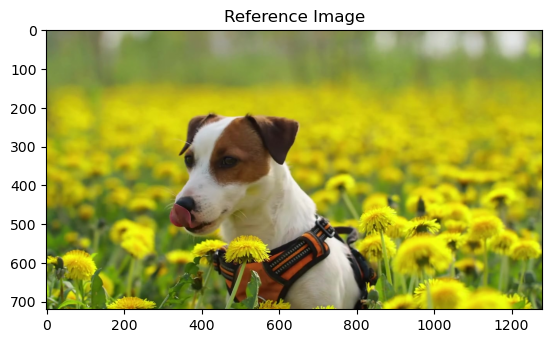

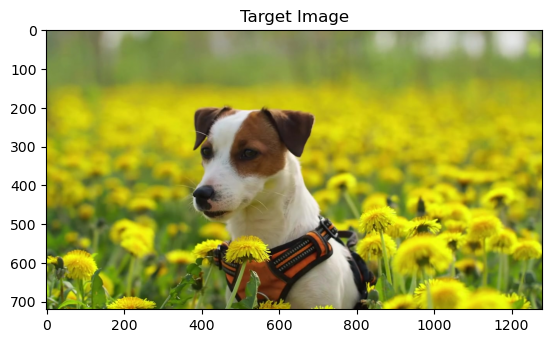

In [9]:
# set image path
ref_img_path = 'src/00080.jpg'
target_img_path = 'src/00084.jpg'

# read image
ref_img = cv2.imread(ref_img_path)
target_img = cv2.imread(target_img_path)

# convert image
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

# show image
plt.title("Reference Image")
plt.imshow(ref_img)
plt.show()

plt.title("Target Image")
plt.imshow(target_img)
plt.show()

Total SAD: 15581808
PSNR: 17.97146353079462


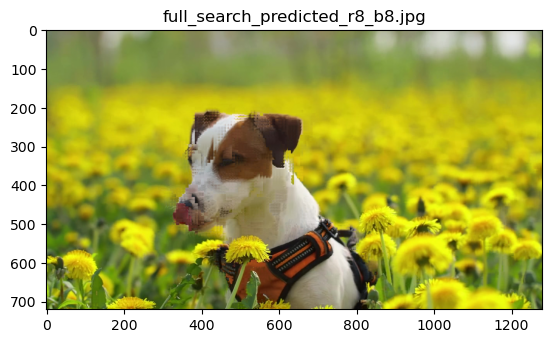

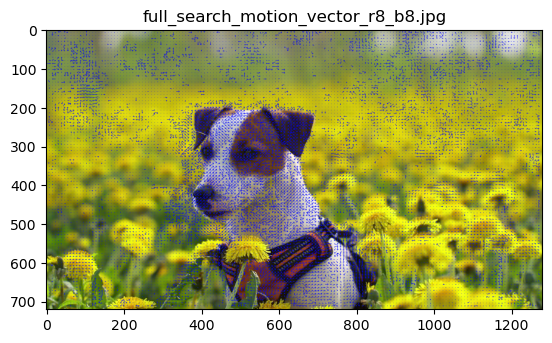

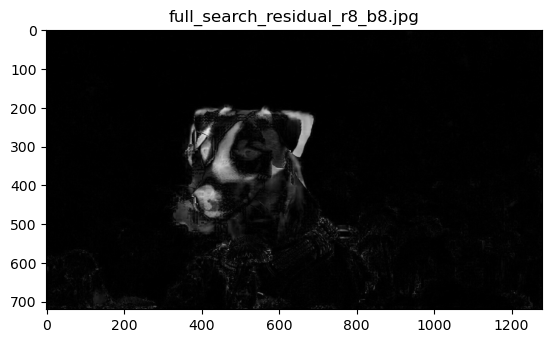

True

In [10]:
# method=full_search, search_range=8, block_size=8
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=8, block_size=8, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "full_search_predicted_r8_b8.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "full_search_motion_vector_r8_b8.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=8)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
file_name = "full_search_residual_r8_b8.jpg"
residual_img = get_residual_img(predicted_img, target_img)
plt.title(file_name)
plt.imshow(residual_img, cmap='gray')
plt.show()
cv2.imwrite('output/' + file_name, residual_img)

Total SAD: 17706468
PSNR: 17.43626037801124


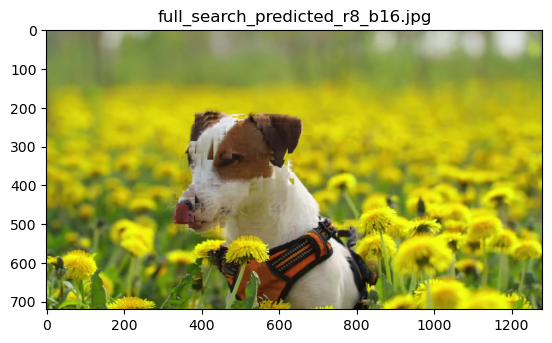

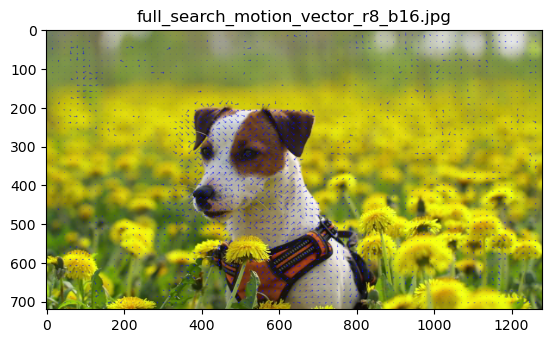

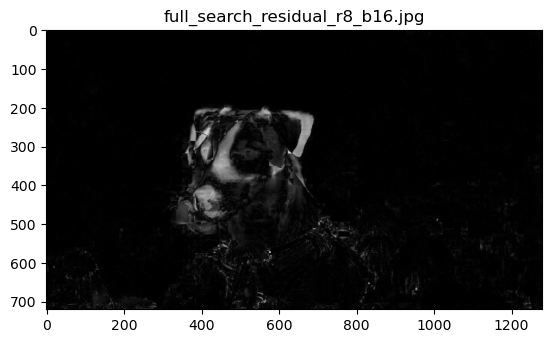

True

In [11]:
# method=full_search, search_range=8, block_size=16
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "full_search_predicted_r8_b16.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "full_search_motion_vector_r8_b16.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=16)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
file_name = "full_search_residual_r8_b16.jpg"
residual_img = get_residual_img(predicted_img, target_img)
plt.title(file_name)
plt.imshow(residual_img, cmap='gray')
plt.show()
cv2.imwrite('output/' + file_name, residual_img)

Total SAD: 11040193
PSNR: 21.07416417583639


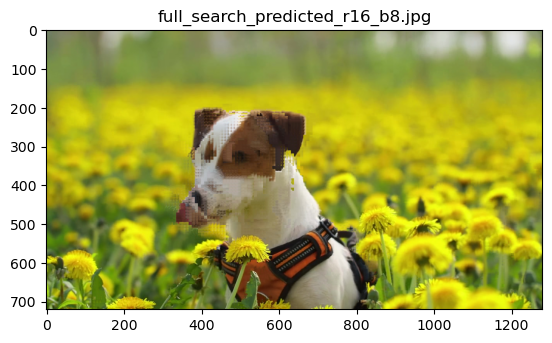

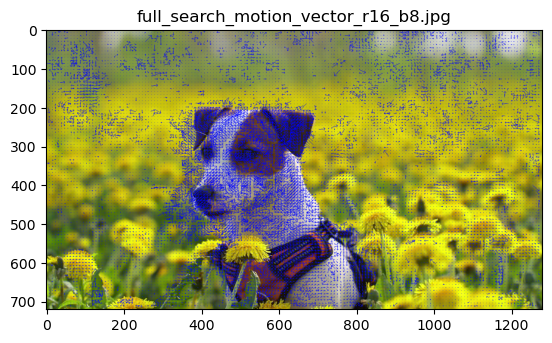

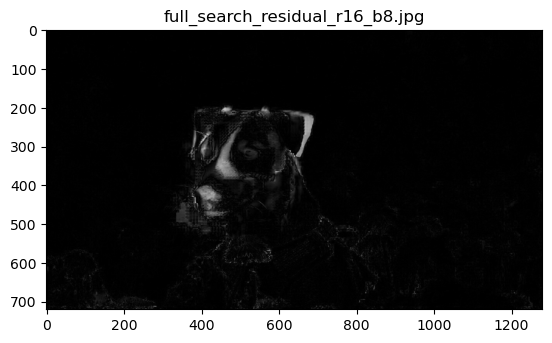

True

In [12]:
# method=full_search, search_range=16, block_size=8
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=16, block_size=8, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "full_search_predicted_r16_b8.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "full_search_motion_vector_r16_b8.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=8)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
file_name = "full_search_residual_r16_b8.jpg"
residual_img = get_residual_img(predicted_img, target_img)
plt.title(file_name)
plt.imshow(residual_img, cmap='gray')
plt.show()
cv2.imwrite('output/' + file_name, residual_img)

Total SAD: 13451470
PSNR: 19.93760053272161


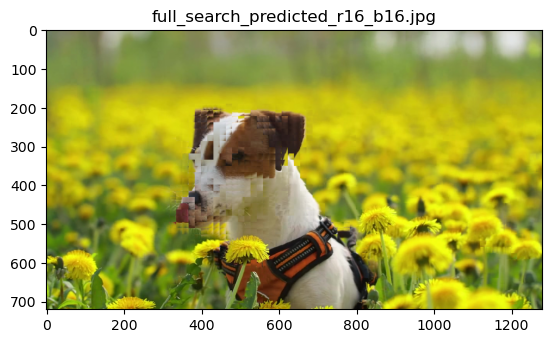

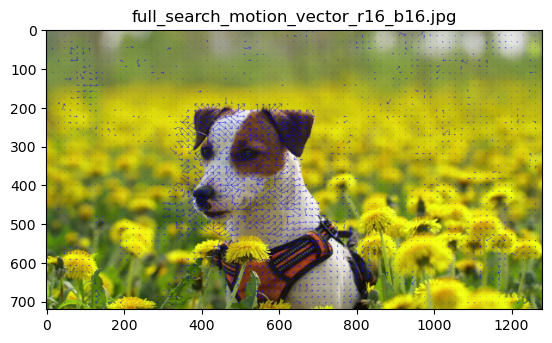

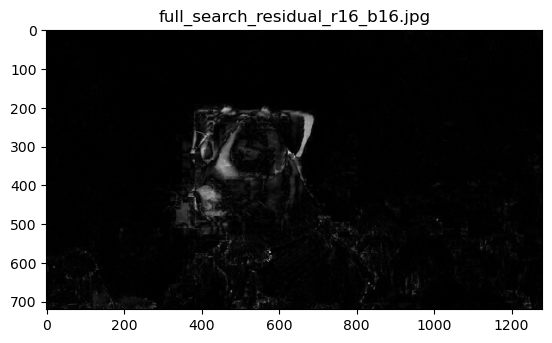

True

In [13]:
# method=full_search, search_range=16, block_size=16
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "full_search_predicted_r16_b16.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "full_search_motion_vector_r16_b16.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=16)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
file_name = "full_search_residual_r16_b16.jpg"
residual_img = get_residual_img(predicted_img, target_img)
plt.title(file_name)
plt.imshow(residual_img, cmap='gray')
plt.show()
cv2.imwrite('output/' + file_name, residual_img)

Total SAD: 16382487
PSNR: 16.41497734018497


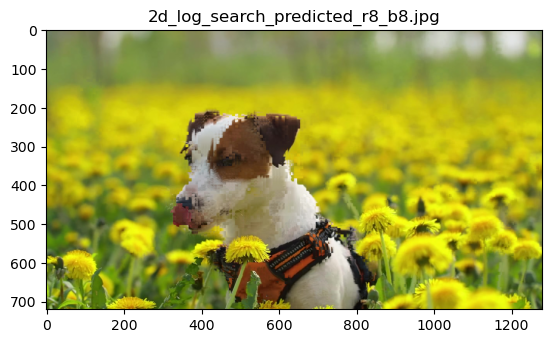

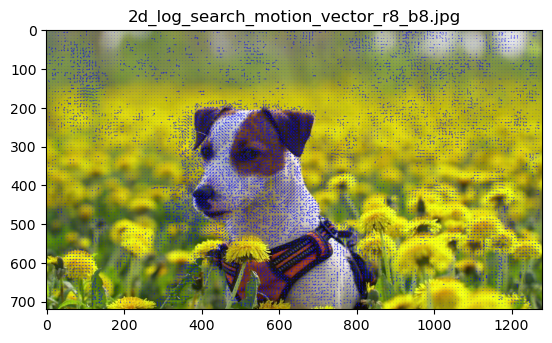

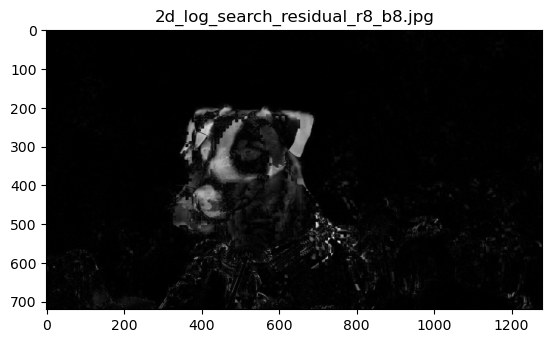

True

In [14]:
# method=2d_log_search, search_range=8, block_size=8
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=8, block_size=8, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "2d_log_search_predicted_r8_b8.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "2d_log_search_motion_vector_r8_b8.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=8)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
file_name = "2d_log_search_residual_r8_b8.jpg"
residual_img = get_residual_img(predicted_img, target_img)
plt.title(file_name)
plt.imshow(residual_img, cmap='gray')
plt.show()
cv2.imwrite('output/' + file_name, residual_img)

Total SAD: 18024776
PSNR: 16.10608728496025


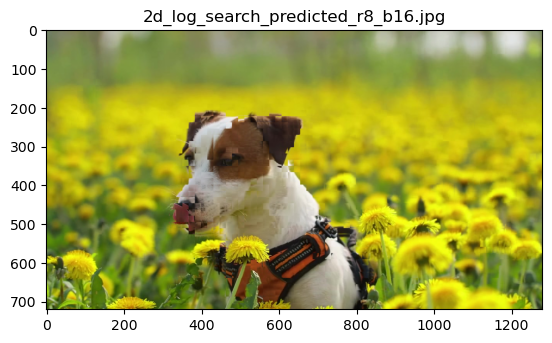

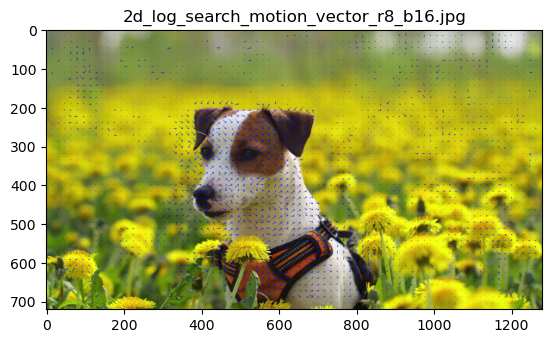

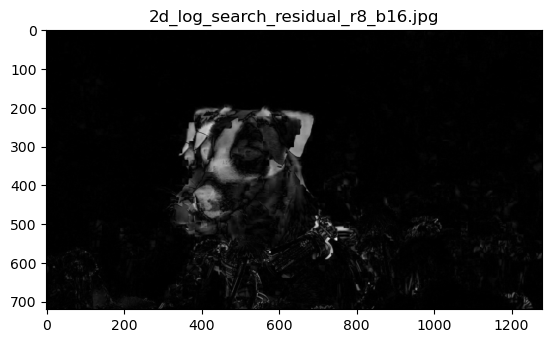

True

In [15]:
# method=2d_log_search, search_range=8, block_size=16
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "2d_log_search_predicted_r8_b16.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "2d_log_search_motion_vector_r8_b16.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=16)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
file_name = "2d_log_search_residual_r8_b16.jpg"
residual_img = get_residual_img(predicted_img, target_img)
plt.title(file_name)
plt.imshow(residual_img, cmap='gray')
plt.show()
cv2.imwrite('output/' + file_name, residual_img)

Total SAD: 13532332
PSNR: 17.282165028329686


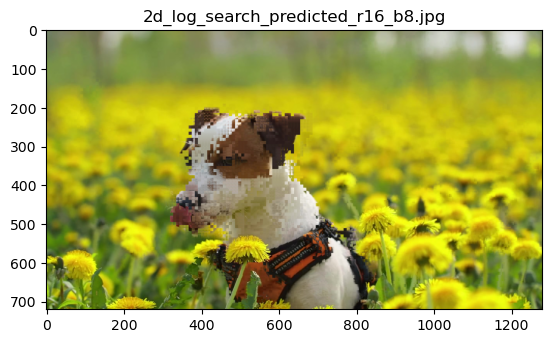

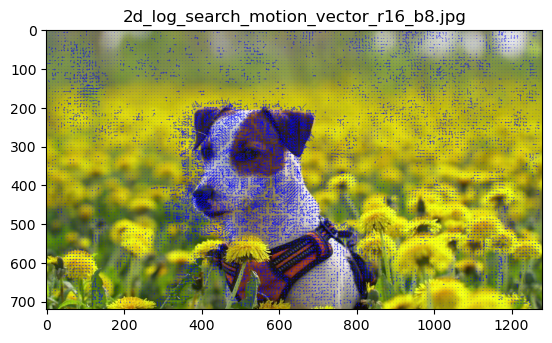

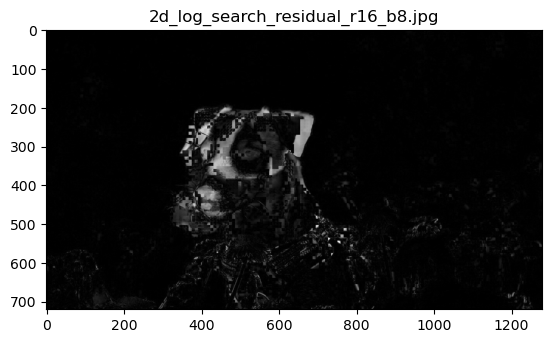

True

In [16]:
# method=2d_log_search, search_range=16, block_size=8
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=16, block_size=8, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "2d_log_search_predicted_r16_b8.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "2d_log_search_motion_vector_r16_b8.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=8)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
file_name = "2d_log_search_residual_r16_b8.jpg"
residual_img = get_residual_img(predicted_img, target_img)
plt.title(file_name)
plt.imshow(residual_img, cmap='gray')
plt.show()
cv2.imwrite('output/' + file_name, residual_img)

Total SAD: 14269084
PSNR: 17.33881696187819


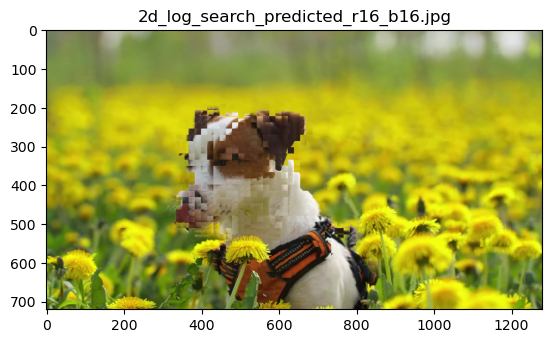

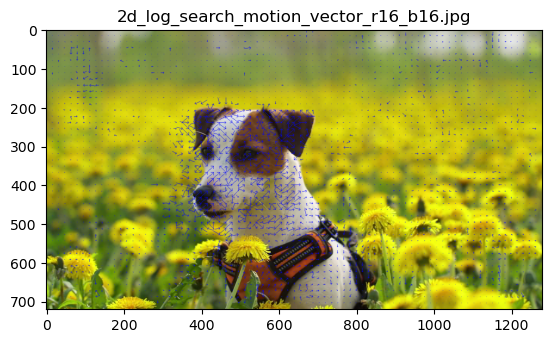

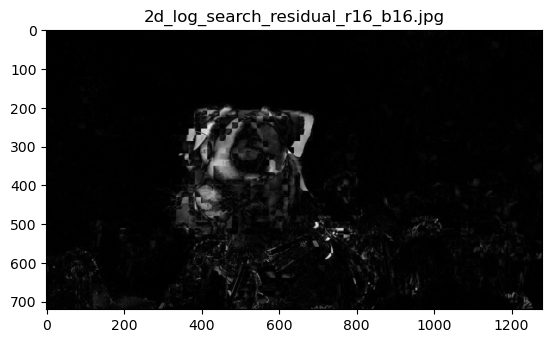

True

In [17]:
# method=2d_log_search, search_range=16, block_size=16
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "2d_log_search_predicted_r16_b16.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "2d_log_search_motion_vector_r16_b16.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=16)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
file_name = "2d_log_search_residual_r16_b16.jpg"
residual_img = get_residual_img(predicted_img, target_img)
plt.title(file_name)
plt.imshow(residual_img, cmap='gray')
plt.show()
cv2.imwrite('output/' + file_name, residual_img)

### Section 1 Report

- 首先比較full search以及2d log search，兩者不論是什麼search range和block size的組合都是full search所呈現的結果較好，失真較少，這是因為full search會在範圍內進行全部的搜尋，所以結果比較精準，但2d log search的好處就是所需要的執行時間遠低於full search，執行效率可以大幅提升。
- 其次就是search range較大時，所呈現出來的結果較好，因為可以做比對的macroblock會變多，使得match的效果較精準，但是相反，所需要的時間也會比較久。
- 最後block size較大時，失真也會比較大一點，可能是因為一個block內的pixel變化較多時，SAD所呈現出來的數字並不能很好的代表該block是否是最佳的match，有可能SAD的數值較小，但是視覺上的效果沒有那麼好，使得顆粒感比較明顯。

## **Section 2 - Temporal Performance Analysis of Motion Estimation (30%)**
Implement the 2D Logarithmic Search method across an entire video sequence using a search range of p=16 and macroblock size of 16x16. The sequence starts with the reference frame ‘00050.jpg’, and subsequent frames in the video serve as target images.

In [18]:
def frames_to_video(image_folder, video_path, frame_width, frame_height, fps=30, img_postfix='.jpg'):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))
    images = glob.glob(os.path.join(image_folder, '*'+img_postfix))
    images.sort()
    for image_file in images:
        img = cv2.imread(image_file)
        if img is not None:
            img = cv2.resize(img, (frame_width, frame_height))
            video_writer.write(img)
    video_writer.release()
    
    print(f'Video saved as {video_path}')

In [19]:
# set image path
ref_img_path = 'src/00050.jpg'
ref_img = cv2.imread(ref_img_path)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

# get image list
img_list = np.sort(os.listdir('src'))
img_list = img_list[1:]

total_SAD_list = []
PSNR_list = []

# generate predict and residual image frames
for img_dir in img_list:
    # read and convert image
    target_img_path = 'src/' + img_dir
    target_img = cv2.imread(target_img_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    
    # motion estimation
    motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)
    residual_img = get_residual_img(predicted_img, target_img)
    PSNR = calculate_PSNR(predicted_img, target_img)
    total_SAD_list.append(total_sad)
    PSNR_list.append(PSNR)
    
    # write image frame
    output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('predicted_frames/' + img_dir, output_img)
    cv2.imwrite('residual_frames/' + img_dir, residual_img)
    
    print(img_dir, ":")
    print("Total SAD:",total_sad)
    print("PSNR:", PSNR)
    print()
    

00051.jpg :
Total SAD: 3891620
PSNR: 31.02718993395669

00052.jpg :
Total SAD: 5071330
PSNR: 28.585081925823133

00053.jpg :
Total SAD: 6081321
PSNR: 26.54217288508518

00054.jpg :
Total SAD: 6697027
PSNR: 24.870270889267992

00055.jpg :
Total SAD: 7275938
PSNR: 23.601486708110947

00056.jpg :
Total SAD: 7818398
PSNR: 23.141142183413766

00057.jpg :
Total SAD: 8475177
PSNR: 22.16787520614798

00058.jpg :
Total SAD: 9344595
PSNR: 21.32806929600911

00059.jpg :
Total SAD: 10443812
PSNR: 20.309797678697727

00060.jpg :
Total SAD: 11633114
PSNR: 19.9028297551898

00061.jpg :
Total SAD: 12750557
PSNR: 18.839473055880106

00062.jpg :
Total SAD: 14001020
PSNR: 18.402306442635304

00063.jpg :
Total SAD: 15827495
PSNR: 17.54219610143388

00064.jpg :
Total SAD: 17965244
PSNR: 16.703020310069988

00065.jpg :
Total SAD: 19965680
PSNR: 16.098057998807892

00066.jpg :
Total SAD: 22042562
PSNR: 15.445382460661772

00067.jpg :
Total SAD: 24416858
PSNR: 14.602168259808908

00068.jpg :
Total SAD: 264377

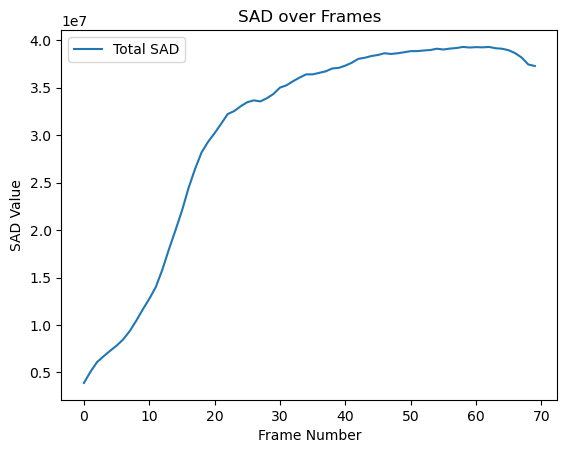

In [20]:
# TODO plot total SAD curve across the video sequence to capture the performance metrics dynamically and describe what you observe
plt.plot(total_SAD_list, label='Total SAD')
plt.title('SAD over Frames')
plt.xlabel('Frame Number')
plt.ylabel('SAD Value')
plt.legend()

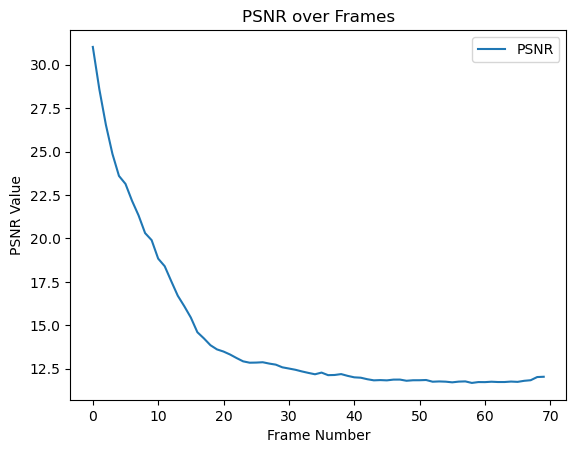

In [21]:
# TODO plot PSNR curve across the video sequence to capture the performance metrics dynamically and describe what you observe
plt.plot(PSNR_list, label='PSNR')
plt.title('PSNR over Frames')
plt.xlabel('Frame Number')
plt.ylabel('PSNR Value')
plt.legend()

In [24]:
# TODO generate predicted images and residual images for each frame in the sequence in relation to the reference frame and compile them into two video files to visualize the temporal consistency of the motion estimation
# frames_to_video('src', 'output/original.mp4', frame_width=1280, frame_height=720, fps=30)
frames_to_video('predicted_frames', 'output/predicted.mp4', frame_width=1280, frame_height=720, fps=30)
frames_to_video('residual_frames', 'output/residual.mp4', frame_width=1280, frame_height=720, fps=30)

Video saved as output/original.mp4
Video saved as output/predicted.mp4
Video saved as output/residual.mp4


### Section 2 Report

- 從圖中可以看出隨著frames越往後，失真就會越大，這是因為單純使用一開始的frame作為reference frame，在往後幾個frame後就沒有辦法很好的還原出這段時間所做出的動作改變，而再繼續往後更是如此。以該例子解釋，一開始的狗頭朝下方，所以在後續狗頭抬起並朝向前時，在reference image裡找不到狗頭正面的細節，也就是找不到best match block，使得失真很大。

## **Section 3 - Computational Efficiency Analysis (10%)**
 - Measure the execution time required for the two search algorithms with the two different search range sizes p=8 and p=16
 - Compare and discuss the execution time with the theoretical time complexity for the two search algorithms

In [23]:
# TODO
import time

# full search p=8 and block size=16
start_time = time.time()
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)
end_time = time.time()
print("Excution time of full search with p=8 and block size=16:", round((end_time - start_time), 2), 's')

# full search p=16 and block size=16
start_time = time.time()
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)
end_time = time.time()
print("Excution time of full search with p=16 and block size=16:", round((end_time - start_time), 2), 's')

# 2d log search p=8 and block size=16
start_time = time.time()
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)
end_time = time.time()
print("Excution time of 2d log search with p=8 and block size=16:", round((end_time - start_time), 2), 's')

# 2d log search p=16 and block size=16
start_time = time.time()
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)
end_time = time.time()
print("Excution time of 2d log search with p=16 and block size=16:", round((end_time - start_time), 2), 's')

Excution time of full search with p=8 and block size=16: 3.54 s
Excution time of full search with p=16 and block size=16: 14.14 s
Excution time of 2d log search with p=8 and block size=16: 0.36 s
Excution time of 2d log search with p=16 and block size=16: 0.49 s


### Section 3 Report

- 從結果可以看出，full search並且search range較大時，所需的執行時間最久，因為full search會將search range內所有點都看過一次，所以其time complexity簡單可以看成O(p^2)
- 而2d log search則是一次比較5個點，並且每次間隔的移動都會是block size的一半，而若是周遭四點比中心點的失真更大時，會縮小間隔再做更精細的搜尋，所以其time complexity簡單可以看成O(lg(p))
- 從以上的time complexity可以看出，full search的複雜度比2d log search還要來的大很多，這也印證了上方執行p=16時，時間上的差異很巨大，2d log search的效率來得好上很多。